# Development of Quarterly QA on Siemens Scanners

This will be performed on the Siemens 'long bottle' phantom in the most used head coil. This is the phantom used for the Siemens coil QA and it can be easily positioned using the dedicated Siemens foam pad.

We'll need to check that this phantom is available on all the scanners. If not then we may need to drop back to using the short bottle and its holder. We should be able to code round the variation - the short bottle has a slightly larger diameter so we can identify the phantom from this.

We'll acquire the following images:
 - SE, 2 acqusitions, with/without PSN, multiple elements, RMS coil combine -> SNR, Unif, XY gradient scale
 - SE, 2 acquisitions, without PSN, multiple elements, RMS coil combine, TX switched off by setting voltages to zero
 - TSE, 1 acquisition, ghosting -> short term stability
 - EPI, 60+ acquisitions, ghosting and long term stability, eddy currents and shim (distortion)

Other possible acquisitions to consider:
 - SE, multiple flip angles
 - CPMG service shim sequence
 - Siemens flip angle mapper
 - SE-EPI diffn for eddy currents -> measure variability in circularity (as encoding directions change)
 
Measurements to be made:
 - SNR, over 50% and (say) 80% of phantom
 - Non-circularity of edge of phantom
 - NMEA uniformity measure using smoothing kernel eg `[[1,2,1,],[2,4,2],[1,2,1]]` - 'normalised absolute deviation'
 - Ghosting on SE/TSE/EPI

### Boiler plate

In [1]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

from mriqa.phantoms import phantom_mask_2d, find_phantom, SIEMENSLONGBOTTLE
from mriqa.dcmio import (
    fetch_series, rx_coil_name, approx_slice_orientation,
    approx_phase_orientation, series_number, seq_name, protocol_name,
    pix_spacing_yx
)
from mriqa.reports import snr_report, ghosting_report, uniformity_report
from mriqa.tools import mean_im, diff_im, snr_im, snr
from dcmextras.siemenscsa import csa, phoenix
import pandas as pd
import warnings

### Series Index
Details of series to analyse.

In [2]:
patid = 'PQACRK20161215'
studyid = '1'
series = {
    'Signal': [26, 30],
    'Signal_Combined': [27, 31],
    'Noise': [22, 24],
    'Noise_Combined': [23, 25],
    'Geometry': [28, 32]
}

### Geometry
For geometrical measures we want to look at the average of the coil-combined images with *Prescan Normalise* intensity correction applied. This will give us the highest SNR and the most uniform image. The should make the segmentation more robust.

In [3]:
dobjs = fetch_series(patid, studyid, sernos=series['Geometry'])
ims = np.asarray([d.pixel_array for d in dobjs], dtype='float')
im = ims.sum(axis=0)

We'll want to interpolate the image up. The default interpolation in ndimage.zoom is spline based. In principle a sinc interpolation would be optimal as the signal is band limited. We could do this as follows by zero filling the fft.

In [4]:
# this doesn't seem to be much better than the spline based zoom
def zoom_f(im, zoom_factor):
    ft = np.fft.fftshift(np.fft.fft2(im))
    ny, nx = int(im.shape[0] * (zoom_factor - 1) // 2), int(im.shape[1] * (zoom_factor - 1) // 2)
    ft_pad = np.pad(ft, ((ny,ny), (nx, nx)), 'constant')
    return np.fft.ifft2(np.fft.fftshift(ft_pad)).real

However, in practice this seems to make little difference so we'll stick with ndimage.zoom.

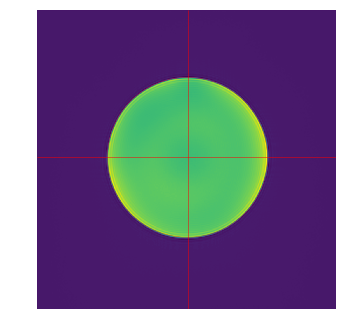

Interpolated Pixel Dimensions: 0.244 x 0.244 mm
Phantom Centre: 516, 505 pixels; Phantom Radius: 274 pixels, 66.89 mm


In [5]:
from scipy.ndimage import zoom

zoom_factor = 4.0

# in pinciple better but in practice makes no differnce
# im = zoom_f(im, zoom_factor)
im = zoom(im, zoom_factor)

plt.imshow(im, cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.grid(False)

# Centre phantom
pix_dims = np.asarray(dobjs[0].PixelSpacing) / zoom_factor

expected_radius = SIEMENSLONGBOTTLE['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(im, expected_radius=expected_radius)
plt.axvline(centre_x, linewidth=0.5, color='red')
plt.axhline(centre_y, linewidth=0.5, color='red')

circle  = plt.Circle((centre_x, centre_y), radius, color='red', fill=False)
plt.gcf().gca().add_artist(circle);
plt.show()

print('Interpolated Pixel Dimensions: %0.3f x %0.3f mm' % tuple(pix_dims))
print('Phantom Centre: %d, %d pixels; Phantom Radius: %d pixels, %0.2f mm' % (centre_x, centre_y, radius, radius*pix_dims[0]))


We want to take a series of radial profiles at different angles about the centre and plot their length as a function of angle. If, in addition, we plot the difference between the distances from the centre to the edge we'll have a measure of any off-centre, but the profile lengths should be pretty insensitive to this. The profiles are full diameters crossing the 'centre' half way along.

In [6]:
from scipy.ndimage import map_coordinates

def radial_profiles(image, centre, radius, ntheta=180, npoints=512, margin=1.25):
    """
    Sequence of radial profiles across diameter through the given centre over a range of angles.
    Image should already be interpolated up.
    """
    centre_x, centre_y =  centre

    # symmetrically about zero
    R = radius * margin
    theta = np.linspace(-np.pi/2, np.pi/2, ntheta)
    xas, yas = R * np.cos(theta), R * np.sin(theta)
    xbs, ybs = -xas, -yas

    # then add in offset to centre
    xas += centre_x
    xbs += centre_x
    yas += centre_y
    ybs += centre_y

    r = []
    for xa, xb, ya, yb in zip(xas, xbs, yas, ybs):
        x = np.linspace(xa, xb, npoints)
        y = np.linspace(ya, yb, npoints)
        r.append(map_coordinates(image, np.vstack((y, x))))
    r =  np.asarray(r)

    delta_r = 2 * R / npoints
    
    return r, theta, delta_r 

In [7]:
def plot_profile_images(r):
    nprofiles, npoints = r.shape

    # derivatives of profiles
    dr = np.gradient(r, axis=-1)

    # derivatives with negative edge flipped positive (better than just abs())
    split = npoints // 2
    sdr = dr.copy()
    sdr[:, split:] *= -1

    # second derivative
    ddr = np.gradient(sdr, axis=-1)

    # plots
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.ravel()

    axs[0].imshow(r, cmap='viridis')
    axs[0].axis('off')
    axs[0].grid(False)

    axs[1].imshow(dr, cmap='coolwarm')
    axs[1].axis('off')
    axs[1].grid(False);

    axs[2].imshow(sdr, cmap='viridis')
    axs[2].axis('off')
    axs[2].grid(False)

    axs[3].imshow(ddr, cmap='coolwarm')
    axs[3].axis('off')
    axs[3].grid(False)

    fig.tight_layout()

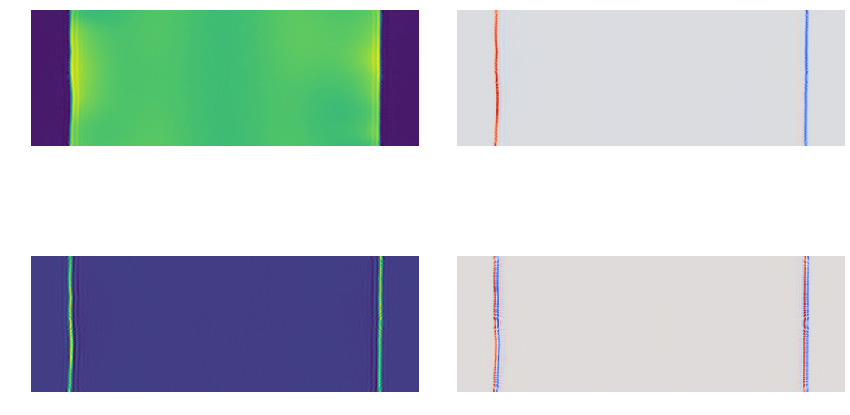

In [8]:
# We assume an isotropic image
assert pix_dims[0] == pix_dims[1]
plot_profile_images(radial_profiles(im, (centre_x, centre_y), radius)[0])

There's not too much of an off-centre, though there is a bit of a wobble. Let's plot all the edges over the top of each other to see this more clearly.

In [9]:
def plot_profiles_overlaid(r):
    nprofiles, npoints = r.shape
    # derivatives of profiles
    dr = np.gradient(r, axis=-1)
    
    # derivatives with negative edge flipped positive (better than just abs())
    split = npoints // 2
    sdr = dr.copy()
    sdr[:, split:] *= -1

    # second derivative
    ddr = np.gradient(sdr, axis=-1)

    # plots (with the middle parts of the profiles excised for clarity)
    fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12, 8))
    axs = axs.ravel()

    l0, l1 = npoints//16, 3*npoints//16
    r0, r1 = 13*npoints//16, 15*npoints//16
    alpha = 5/nprofiles
    for profile in r:
        axs[0].plot(np.hstack([profile[l0:l1], profile[r0:r1]]), '-', alpha=alpha)

    axs[0].axis('tight')
    axs[0].set_title(r'$S(r)$')
    axs[0].grid(True)

    for profile in dr:
        axs[1].plot(np.hstack([profile[l0:l1], profile[r0:r1]]), '-', alpha=alpha)
    axs[1].axis('tight');
    axs[1].set_title(r'$\mathrm{d}S / \mathrm{d}r$')
    axs[1].grid(True)

    for profile in sdr:
        axs[2].plot(np.hstack([profile[l0:l1], profile[r0:r1]]), '-', alpha=alpha)
    axs[2].axis('tight');
    axs[2].set_title(r'Symmetrised $\mathrm{d}S / \mathrm{d}r$')
    axs[2].set_xlabel('Index Position in Profiles')
    axs[2].grid(True)

    for profile in ddr:
        axs[3].plot(np.hstack([profile[l0:l1], profile[r0:r1]]), '-', alpha=alpha)
    axs[3].axis('tight');
    axs[3].set_title(r'$\mathrm{d}^2S / \mathrm{d}r^2$')
    axs[3].set_xlabel('Index Position in Profiles')
    axs[3].grid(True)
 
    fig.tight_layout()

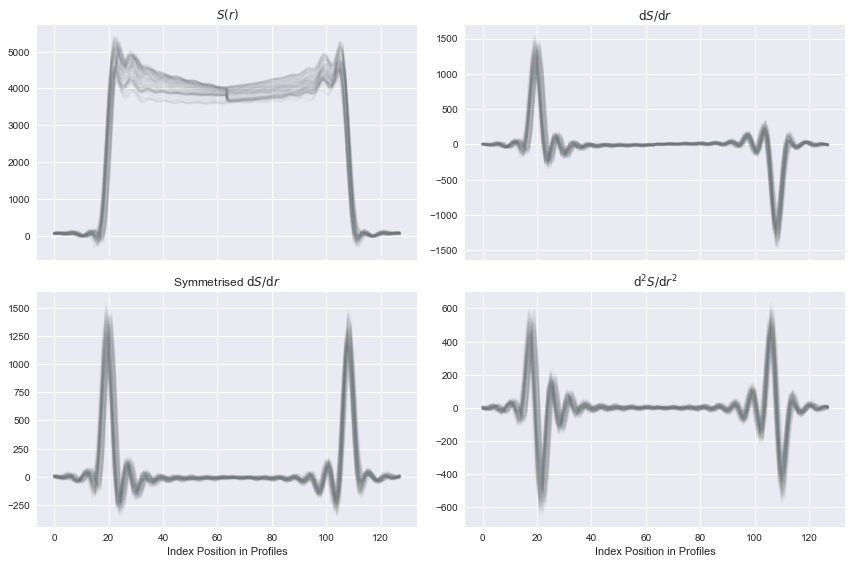

In [10]:
plot_profiles_overlaid(radial_profiles(im, (centre_x, centre_y), radius)[0])

First, we'll find the phantom edges based on the maximum in the profile derivative (with the trailing edge flipped over so both of them are positive).

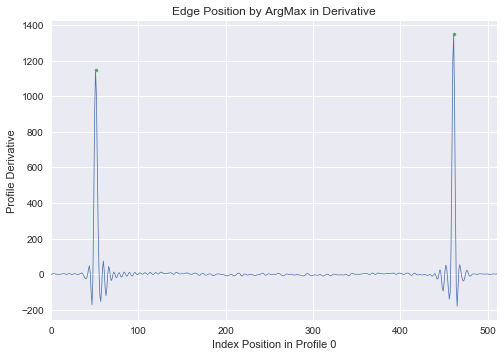

In [11]:
def positive_gradient(r):
    # flip sign of second edge to make both positive]
    nprofiles, npoints = r.shape
    dr = np.gradient(r, axis=-1)
    # derivatives with negative edge flipped positive (better than just abs())
    split = npoints // 2
    dr[:, split:] *= -1 
    return dr

sdr = positive_gradient(radial_profiles(im, (centre_x, centre_y), radius)[0])
split = sdr.shape[1] // 2
n = 0
x0 = np.argmax(sdr[n][:split])
x1 = np.argmax(sdr[n][split:]) + split

plt.plot(sdr[n], '-', alpha=1.0, linewidth=0.75)
plt.plot([x0, x1], [sdr[n][x0], sdr[n][x1]], '.')
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('Index Position in Profile %d' % n)
plt.ylabel('Profile Derivative')
plt.grid(True)
plt.title('Edge Position by ArgMax in Derivative');

Find all the edge points this way and plot the length of the profile as a function of angle. 

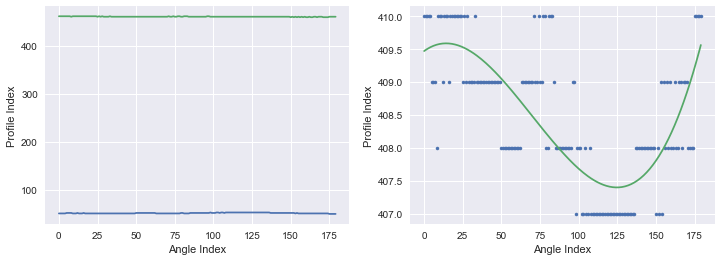

In [12]:
from scipy.signal import savgol_filter

x0_x1 = []
for line in positive_gradient(radial_profiles(im, (centre_x, centre_y), radius)[0]):
    x0 = np.argmax(line[:split]) 
    x1 = np.argmax(line[split:]) + split
    x0_x1.append((x0, x1))
x0, x1 = np.array(x0_x1).T
dx = x1 - x0

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(x0)
axs[0].plot(x1)
axs[0].set_xlabel('Angle Index')
axs[0].set_ylabel('Profile Index')
axs[0].grid(True)

axs[1].plot(dx, '.');
axs[1].plot(savgol_filter(dx, len(dx)-1, 3), '-')
axs[1].set_xlabel('Angle Index')
axs[1].set_ylabel('Profile Index')
axs[1].grid(True);

To refine this further we could consider:
 - get sub-pixel estimates of the edge positions
 - check the interpolation that is being done by `map_coordinates`
   - in fact this is a spline

The `peakutils` package has a subpixel peak refinement routine `interpolate` which fits a gaussian to previously estimated peaks. We'll try doing the same.

In [13]:
from scipy.optimize import curve_fit
from warnings import warn

def gaussian_fit(x, y):
    def gaussian(x, ampl, centre, stdev):
        return ampl * np.exp(-(x - float(centre)) ** 2 / (2.0 * stdev ** 2 + np.finfo(float).eps))
    
    if len(x) < 3:
        raise RuntimeError("At least 3 points required for Gaussian fitting")

    ampl_0, centre_0, stddev_0 = np.max(y), (x[0] + x[-1])/2, (x[1] - x[0]) * 2
    initial = [ampl_0, centre_0, stddev_0]
    lower_bounds = [0.75 * ampl_0, centre_0 - 2.0, stddev_0 / 4]
    upper_bounds = [1.25 * ampl_0, centre_0 + 2.0, 2 * stddev_0]
    
    try:
        params, _ = curve_fit(gaussian, x, y, initial, xtol=0.01, bounds=(lower_bounds, upper_bounds))
    except RuntimeError as e:
        # print(window, index)
        warn("gaussian_fit: fitting error [%s] (trying a looser tolerance)" % e)
        params, _ = curve_fit(gaussian, x, y, initial, xtol=0.25, bounds=(lower_bounds, upper_bounds))
    return params[1]


def refine_peak(row, index, window_half_width=8):
    """
    Refine a peak position previously determined with argmax
    """
    if not (window_half_width <= index < len(row) + window_half_width, index):
        warn('peak too close to edge in refine_peak')
        return float(index)

    # centre window on previsously detected peak
    y = row[index-window_half_width:index+window_half_width]
    x = np.arange(len(y))
    
    # try and fit a gaussian
    try:
        return gaussian_fit(x, y) + index - window_half_width
    except RuntimeError as e:
        warn("refine_peak: %s" % e)
        return float(index)

OK, that seems bit better. It also looks like an erf based fit could also work quite well. There is some degree of edge ringing and I'm not sure how we'd model that.

The centre is probably not exactly right. We could try and optimise this based on some measurement of the straightness of the edges in the profiles array. Having attempted that though the improvement seems minimal and it's difficult to find a robust objective function to optimise so we'll leave it for now.

We'll try fitting a single sinusoid of aribitrary phase which would correspond to an elliptical image, such as might result from a scaling inconsistency between the x and the y gradients or (in the case of a low readout bandwidth) a first order shim error (ie a gradient offset).

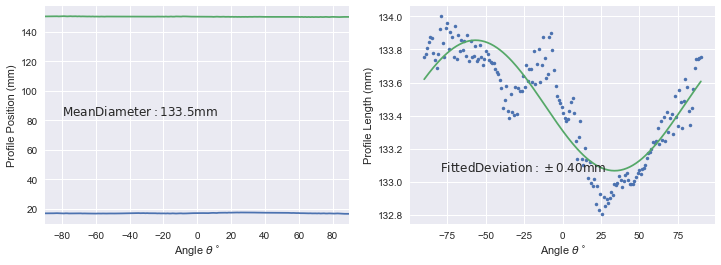

In [14]:
x0_x1 = []

r, theta, delta_r = radial_profiles(im, (centre_x, centre_y), radius)
for line in positive_gradient(r):
    x0 = refine_peak(line[:split], np.argmax(line[:split]))
    x1 = refine_peak(line[split:], np.argmax(line[split:])) + split
    x0_x1.append((x0, x1))

x0, x1 = np.array(x0_x1).T
dx = x1 - x0

# fit a single cycle sinusoid of arbitrary phase
# we are assuming here that the profiles cover a range of angle over exactly a semi-circle
def sinfit(x, offset, a, b):
    phase = np.arange(len(x)) * 2 * np.pi / len(x)
    return offset + a * np.cos(phase) + b * np.sin(phase)
offset, a, b = curve_fit(sinfit, xdata=theta, ydata=dx, p0=(dx.mean(), 0, 0))[0]
dxfit = sinfit(dx, offset, a, b)
devn = np.ptp(dxfit) / 2

delta_r_mm = delta_r * pix_dims[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(np.degrees(theta), x0*delta_r_mm)
axs[0].plot(np.degrees(theta), x1*delta_r_mm)
axs[0].text(-80, ((x0+x1)/2*delta_r_mm).mean(), r'$\mathrm{Mean Diameter: } %0.1f \mathrm{ mm}$' % (dx.mean()*delta_r_mm))
axs[0].set_xlabel(r'Angle $\theta^\circ$')
axs[0].set_ylabel(r'Profile Position (mm)')
axs[0].autoscale(enable=True, axis='x', tight=True)
axs[0].grid(True)
axs[1].plot(np.degrees(theta), dx*delta_r_mm, '.');
axs[1].plot(np.degrees(theta), dxfit*delta_r_mm, '-');
axs[1].text(-80, dxfit.min()*delta_r_mm, r'$\mathrm{Fitted Deviation: } \pm %0.2f \mathrm{ mm}$' % (devn*delta_r_mm))
axs[1].set_xlabel(r'Angle $\theta^\circ$')
axs[1].set_ylabel(r'Profile Length (mm)')
axs[1].axis('tight')
axs[1].grid(True);

The sinusoid fits a significant part of the curve but note there are clearly other components. The sharper ones are likely to be related to the construction of the phantom as it is a soft plastic bottle rather a precision cylinder.
It is likely that it's not exactly circular in cross-section at the seams. 

We could verify this by scanning at much higher resolution and at high bandwidth and seeing if the pattern persists.

We can take a closer look at this peak finding and refining, to check that no systematic errors are introduced there.

In [15]:
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

dr = positive_gradient(radial_profiles(im, (centre_x, centre_y), radius)[0])
nprofiles, npoints = dr.shape
split = npoints // 2

drsub = dr[:, :split]
nprofiles, npoints = drsub.shape

peaks = np.argmax(drsub, axis=1)
refined_peaks = np.array([refine_peak(profile, peak) for profile, peak in zip(drsub, peaks)])

x1 = int(np.round(np.mean(peaks)))
lower, upper = x1 - 15, x1 + 15

i0 = len(drsub) // 2

drsubinterp = [interp1d(np.arange(len(row)), row) for row in drsub]

fig, ax = plt.subplots()
line, = ax.plot(drsub[i0, lower:upper], '-',  alpha=0.5)
line_p, = ax.plot(
    [peaks[i0] - lower],
    [drsub[i0, int(peaks[i0])]],
    'ro', alpha=0.5, label='Peak from Maximum',
)
line_rp, = ax.plot(
    [refined_peaks[i0] - lower],
    [drsubinterp[i0](refined_peaks[i0])],
    'go', alpha=0.5, label='Peak Refined by Fitting',
)

ax.set_ylim(np.min(drsub), np.max(drsub))
ax.grid(True)
ax.set_title('Profile Trailing Edge Peak Finding')
ax.set_xlabel('Nominal Index Position')
ax.set_ylabel('Edge Strength')
ax.legend()

plt.close(fig)

@interact
def plot_single_profile(profile_no=(1, len(dr))):
    i = profile_no - 1
    line.set_ydata(drsub[i, lower: upper])
    line_p.set_ydata([drsub[i, int(peaks[i])]])
    line_p.set_xdata([peaks[i] - lower])
    line_rp.set_ydata([drsubinterp[i](refined_peaks[i])])
    line_rp.set_xdata([refined_peaks[i] - lower])
    display(fig)

This seems to correspond pretty closely to the peak position identified by eye. Given the scale of the non-cicularity and the component that is not well fitted by a sinusoid we may well be measuring the phantom construction quality as much as the MR system performance.